In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from py2neo import Graph, Node, Relationship

In [4]:
from lg_utils import connect_to_graph, count_nodes, count_rels, load_csv, add_csv_to_graph, add_relationships, add_nodes_df_to_graph

In [5]:
graph = connect_to_graph()

## Write Louvain community and PageRank

*Note*: For present, best to run in Neo4J browser, but recording here.
*Note*: At present the graph needs a heap size of ~600-700mb, and default Neo4J setting is 512mb, so increase that before running these to avoid out of memory errors

In [8]:
create_mem_graph = True

if create_mem_graph:
    graph_create_query = """
        CALL gds.graph.create.cypher('connected-nodes-graph', 
            'match (n) where (n)--() return id(n) as id',
            'match (n)--(m) return id(n) as source, id(m) as target'
        ) 
        YIELD graphName, nodeCount, relationshipCount, createMillis
    """
    graph.run(graph_create_query).evaluate()

KeyboardInterrupt: 

In [7]:
write_page_rank = True

if write_page_rank:
    page_rank_write_query = """
        CALL gds.pageRank.write('connected-nodes-graph', { writeProperty: 'page_rank_score' })
            YIELD nodePropertiesWritten, ranIterations
    """
    graph.run(page_rank_write_query).evaluate()

ClientError: [Procedure.ProcedureCallFailed] Failed to invoke procedure `gds.pageRank.write`: Caused by: java.util.NoSuchElementException: Cannot find graph with name 'connected-nodes-graph'.

In [12]:
write_louvain = True

if write_louvain:
    louvain_write_query = """
        CALL gds.louvain.write('connected-nodes-graph', { writeProperty: 'l_community' })
        YIELD communityCount, modularity, modularities
    """
    graph.run(louvain_write_query).evaluate()

ClientError: [Procedure.ProcedureNotFound] There is no procedure with the name `gds.louvain.write` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.

## Exploring state centrality, and state-community mapping

In [11]:
state_nodes = graph.run("match (s:State) return s").to_data
df = pd.DataFrame.from_records(state_nodes, columns=state_nodes.keys())

AttributeError: 'Cursor' object has no attribute 'to_data'

In [ ]:
df = graph.run("""
    match (c:Case)-[:IN_STATE]->(s:State) return s.state_id, s.state_name, s.page_rank_score, s.l_community, count(distinct(c)) as case_count
""").to_data_frame()

In [50]:
df.sort_values("s.page_rank_score", ascending=False)

,s.state_id,s.state_name,s.page_rank_score,s.l_community,case_count
29,13,Uttar Pradesh,339784.259538,13756485,2550912
18,1,Maharashtra,192323.201093,36909,1374670
14,3,Karnataka,139720.311673,13756193,1101515
24,9,Rajasthan,116115.824256,13756321,865734
17,23,Madhya Pradesh,102851.124163,34599,812987
15,4,Kerala,98942.504840,13756212,705613
9,17,Gujarat,97697.368314,13756586,765934
26,10,Tamil Nadu,91712.640826,13756366,658724
10,14,Haryana,87080.618223,13756537,641501
2,8,Bihar,80617.906326,13756474,612675


In [57]:
df.groupby('s.l_community', as_index=False).agg({ 
    's.state_name': list, 
    'case_count': sum, 
    's.page_rank_score': sum 
}).sort_values('s.page_rank_score', ascending=False)

,s.l_community,s.state_name,case_count,s.page_rank_score
15,13756485,"[Mizoram, Uttar Pradesh]",2552277,339988.917618
2,36909,[Maharashtra],1374670,192323.201093
4,13756193,[Karnataka],1101515,139720.311673
9,13756321,[Rajasthan],865734,116115.824256
16,13756537,"[Haryana, Uttarakhand]",792717,109238.771154
1,34599,[Madhya Pradesh],812987,102851.124163
5,13756212,[Kerala],705613,98942.504840
18,13756586,[Gujarat],765934,97697.368314
10,13756366,[Tamil Nadu],658724,91712.640826
14,13756474,[Bihar],612675,80617.906326


## Now explore judge centrality

In [85]:
judge_query = """
    match (j:Judge)--(c:Case)--(s:State) where j.page_rank_score > 100 return distinct j, s
"""

judge_cursor = graph.run(judge_query)

judge_data = judge_cursor.data()

In [88]:
len(judge_data)

622

In [89]:
judge_data[:3]

[{'j': Node('Judge', judge_end='2018-09-19', judge_female='0 nonfemale', judge_id=34742, judge_position='district and sessions court', judge_start='2018-01-17', l_community=13756212, macro_component_id=0, page_rank_score=227.97813876687616),
  's': Node('State', l_community=13756212, macro_component_id=0, page_rank_score=98942.5048395391, state_id=4, state_name='Kerala')},
 {'j': Node('Judge', judge_end='2018-12-28', judge_female='1 female', judge_id=35951, judge_position='additional chief judicial magistrate', judge_start='2016-09-05', l_community=13756229, macro_component_id=0, page_rank_score=207.34155250754335),
  's': Node('State', l_community=13756229, macro_component_id=0, page_rank_score=46990.42145482522, state_id=5, state_name='Himachal Pradesh')},
 {'j': Node('Judge', judge_end='2018-12-22', judge_female='0 nonfemale', judge_id=35985, judge_position='district and sessions court', judge_start='2017-12-09', l_community=13756229, macro_component_id=0, page_rank_score=162.107452

In [93]:
judge_list = [
    {
        'judge_id': item['j'].get('judge_id'),
        'judge_female': item['j'].get('judge_female'),
        'judge_position': item['j'].get('judge_position'),
        'judge_start': item['j'].get('judge_start'),
        'judge_state': item['s'].get('state_name'),
        'judge_page_rank': item['j'].get('page_rank_score'),
        'state_page_rank': item['s'].get('page_rank_score')
    }
    for item in judge_data
]

In [94]:
jdf = pd.DataFrame(judge_list)

In [97]:
jdf.sort_values('judge_page_rank', ascending=False)

,judge_id,judge_female,judge_position,judge_start,judge_state,judge_page_rank,state_page_rank
129,47932,0 nonfemale,additional chief judicial magistrate,2017-11-14,Rajasthan,1316.755799,116115.824256
510,76774,0 nonfemale,district and sessions court,2018-02-21,West Bengal,1098.338591,57661.908571
80,40655,0 nonfemale,district and sessions court,2017-05-30,Bihar,862.607897,80617.906326
287,61525,0 nonfemale,chief judicial magistrate,2016-09-05,Uttar Pradesh,852.652914,339784.259538
465,75038,1 female,district and sessions court,2018-02-01,West Bengal,749.338188,57661.908571
...,...,...,...,...,...,...,...
560,86816,0 nonfemale,district and sessions court,2017-04-26,Punjab,100.687507,77318.120761
554,86381,0 nonfemale,district and sessions court,2017-04-25,Punjab,100.490501,77318.120761
353,65048,0 nonfemale,civil judge junior division,2017-03-23,Uttar Pradesh,100.455384,339784.259538
498,76371,1 female,district and sessions court,2017-01-30,West Bengal,100.384749,57661.908571


<AxesSubplot:xlabel='state_page_rank', ylabel='judge_page_rank'>

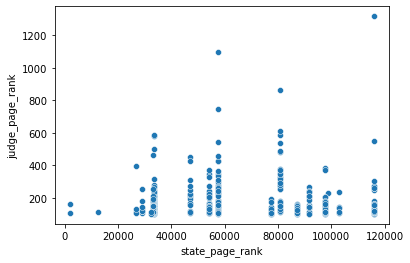

In [105]:
sns.scatterplot(data=jdf[jdf.state_page_rank < 200000], y='judge_page_rank', x='state_page_rank')

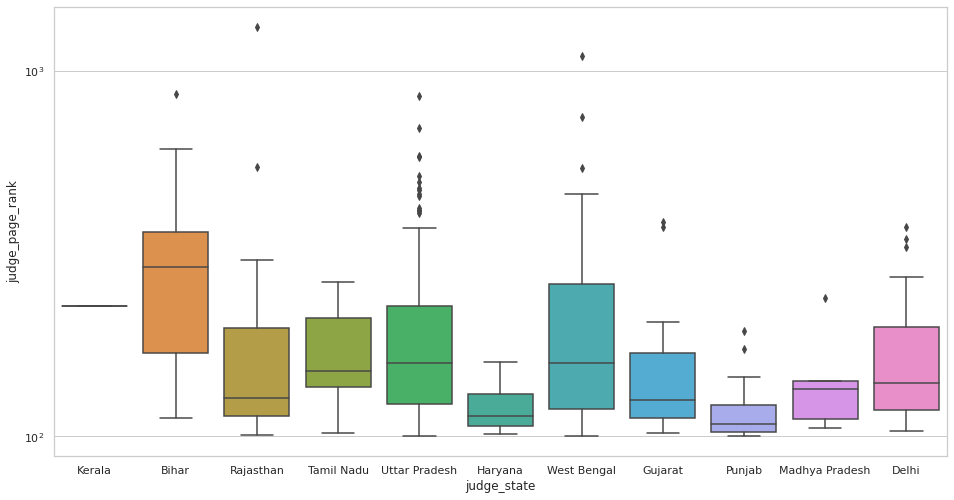

In [135]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16, 8.27))
to_plot = jdf[jdf.state_page_rank > 50000]
sns.boxplot(ax=ax, data=to_plot, y='judge_page_rank', x='judge_state')
ax.set_yscale('log')
# sns.despine(offset=10, trim=True)

## Same thing with acts

In [126]:
adf = graph.run("""
    match (c:Case)-[:USES_ACT]->(a:Act) 
    where exists(a.page_rank_score)
    return a.act_id, a.act_sum, a.l_community, a.page_rank_score, count(distinct(c)) as case_count
""").to_data_frame()

In [132]:
adf.sort_values('a.page_rank_score', ascending=False)[:20]

,a.act_id,a.act_sum,a.l_community,a.page_rank_score,case_count
10250,17698.0,The Indian Penal Code,13756474,541669.400067,3444539
2765,4925.0,Code of Criminal Procedure,13756278,251780.151358,1503727
6332,10818.0,Motor Vehicles Act,13756537,175096.392122,1242801
2761,4913.0,Code of Civil Procedure,13756637,172855.325925,1188198
6617,11244.0,Negotiable Instruments Act,36909,91027.177839,648511
8617,14692.0,Railways Act,13756557,51338.633120,127900
3744,6497.0,Excise Act 1915,34599,27788.708573,116500
4372,7513.0,Hindu Marriage Act,13756485,26155.044360,186657
2324,4214.0,"CODE OF CIVIL PROCEDURE, 1908 (HB)",13756167,20755.710945,144727
4040,6985.0,"GUJARAT (BOMBAY) PROHIBITION ACT, 1949",13756586,18125.533594,117170


In [130]:
communities = adf.groupby('a.l_community', as_index=False).agg({ 
    'a.act_sum': list, 
    'case_count': sum, 
    'a.page_rank_score': sum 
}).sort_values('a.page_rank_score', ascending=False)

## Explore, districts, also act-state relationships

Where to go next:

* See how these scores and communities change if restrict cases to female defendants
* Add in judge relationships on decisions, and again see how these change
* Understand what act L scores are telling us about relationship between acts and states
* Add sections to graph and rerun above, for final analyses

Possible in future:

* Add all the other year's cases and see if any evolution per year